## 线性回归的四大基本假设（必须满足，模型才可靠！）
- 线性关系：自变量和因变量存在线性关系
- 误差独立：残差之间不相关
- 方差齐性：残差方差相等
- 正态性：残差服从正态分布

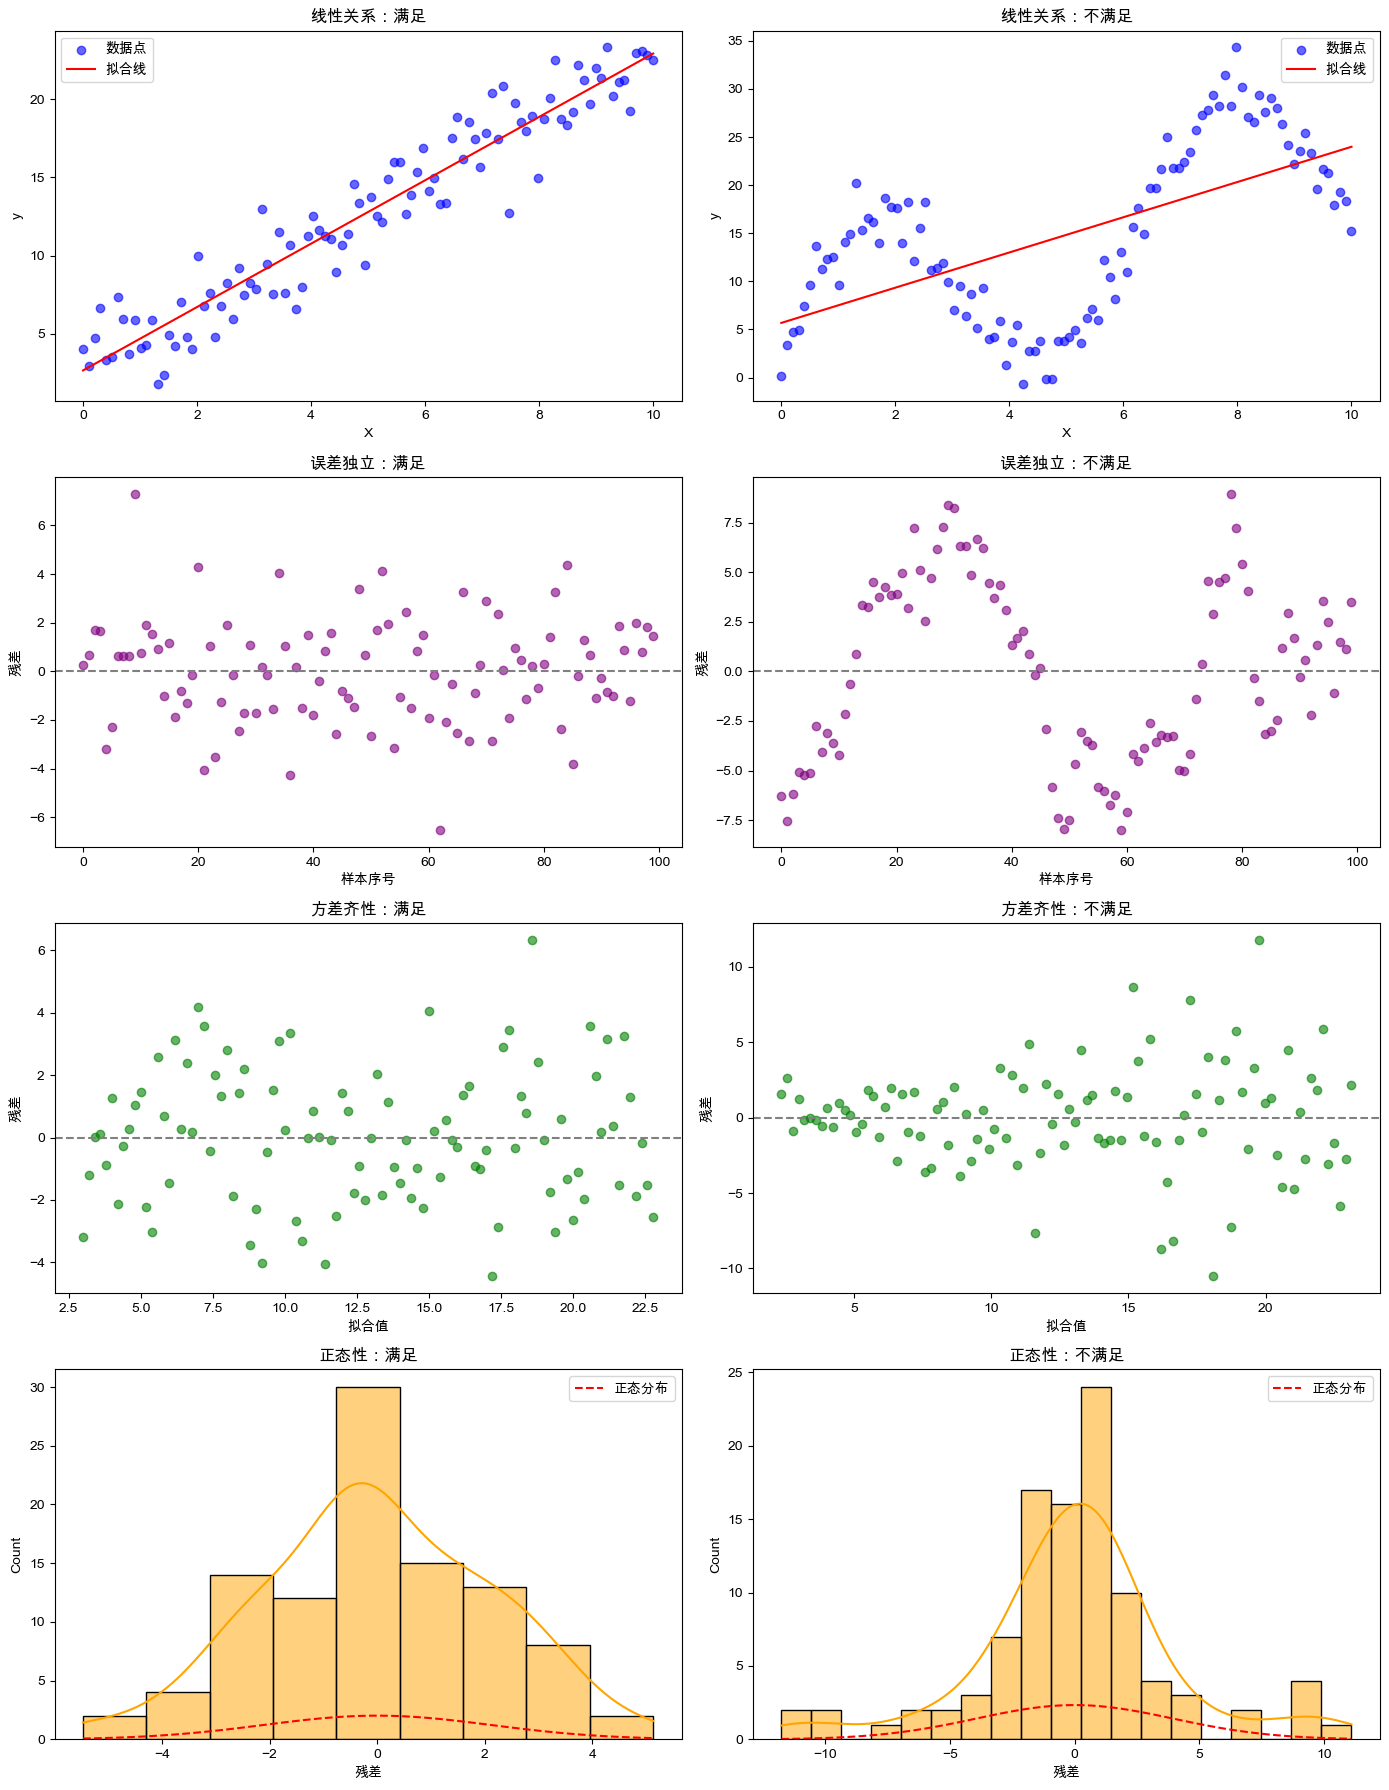

In [57]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from scipy import stats

plt.rcParams['font.family'] = 'Arial Unicode MS'

np.random.seed(42)
X = np.linspace(0, 10, 100)

# 1. 线性关系
y_linear = 2 * X + 3 + np.random.normal(0, 2, 100)  # 满足
y_nonlinear = 2 * X + 3 + 10 * np.sin(X) + np.random.normal(0, 2, 100)  # 不满足

# 2. 误差独立
y_indep = 2 * X + 3 + np.random.normal(0, 2, 100)  # 满足
y_dep = 2 * X + 3 + np.cumsum(np.random.normal(0, 2, 100))  # 不满足（残差有趋势）

# 3. 方差齐性
y_homoscedastic = 2 * X + 3 + np.random.normal(0, 2, 100)  # 满足
y_heteroscedastic = 2 * X + 3 + np.random.normal(0, X/2+1, 100)  # 不满足（残差方差随X增大）

# 4. 正态性
y_normal = 2 * X + 3 + np.random.normal(0, 2, 100)  # 满足
y_nonnormal = 2 * X + 3 + np.random.standard_t(df=2, size=100) * 2  # 不满足（重尾分布）

fig, axes = plt.subplots(4, 2, figsize=(14, 18))
titles = [
    '线性关系：满足', '线性关系：不满足',
    '误差独立：满足', '误差独立：不满足',
    '方差齐性：满足', '方差齐性：不满足',
    '正态性：满足', '正态性：不满足'
]

# 1. 线性关系
for i, (y, title) in enumerate(zip([y_linear, y_nonlinear], titles[:2])):
    model = LinearRegression().fit(X.reshape(-1, 1), y)
    y_pred = model.predict(X.reshape(-1, 1))
    axes[0, i].scatter(X, y, color='blue', alpha=0.6, label='数据点')
    axes[0, i].plot(X, y_pred, color='red', label='拟合线')
    axes[0, i].set_title(title)
    axes[0, i].set_xlabel('X')
    axes[0, i].set_ylabel('y')
    axes[0, i].legend()

# 2. 误差独立
for i, (y, title) in enumerate(zip([y_indep, y_dep], titles[2:4])):
    model = LinearRegression().fit(X.reshape(-1, 1), y)
    y_pred = model.predict(X.reshape(-1, 1))
    residuals = y - y_pred
    axes[1, i].scatter(range(len(residuals)), residuals, color='purple', alpha=0.6)
    axes[1, i].axhline(0, color='gray', linestyle='--')
    axes[1, i].set_title(title)
    axes[1, i].set_xlabel('样本序号')
    axes[1, i].set_ylabel('残差')

# 3. 方差齐性
for i, (y, title) in enumerate(zip([y_homoscedastic, y_heteroscedastic], titles[4:6])):
    model = LinearRegression().fit(X.reshape(-1, 1), y)
    y_pred = model.predict(X.reshape(-1, 1))
    residuals = y - y_pred
    axes[2, i].scatter(y_pred, residuals, color='green', alpha=0.6)
    axes[2, i].axhline(0, color='gray', linestyle='--')
    axes[2, i].set_title(title)
    axes[2, i].set_xlabel('拟合值')
    axes[2, i].set_ylabel('残差')

# 4. 正态性
for i, (y, title) in enumerate(zip([y_normal, y_nonnormal], titles[6:])):
    model = LinearRegression().fit(X.reshape(-1, 1), y)
    y_pred = model.predict(X.reshape(-1, 1))
    residuals = y - y_pred
    sns.histplot(residuals, kde=True, ax=axes[3, i], color='orange')
    x_norm = np.linspace(residuals.min(), residuals.max(), 100)
    axes[3, i].plot(x_norm, stats.norm.pdf(x_norm, residuals.mean(), residuals.std()) * len(residuals) * (x_norm[1]-x_norm[0]), color='red', linestyle='--', label='正态分布')
    axes[3, i].set_title(title)
    axes[3, i].set_xlabel('残差')
    axes[3, i].legend()

plt.tight_layout()
plt.show()

## 算法实现

In [ ]:
# numpy实现线性回归
import numpy as np

class MyLinearRegression:
    def __init__(self, learning_rate=0.01, n_iters=1000, fit_intercept=True, method="gd", alpha=0.0, l1_ratio=0.0):
        # 学习率
        self.learning_rate = learning_rate
        # 迭代次数
        self.n_iters = n_iters
        # 是否拟合截距
        self.fit_intercept = fit_intercept
        # 选择方法（gd为梯度下降法，normal为正规方程）
        self.method = method  # "gd" for gradient descent, "normal" for normal equation
        # 正则化强度【如果为0】
        self.alpha = alpha
        # L1正则化比例【0为纯L2，1为纯L1】
        self.l1_ratio = l1_ratio  
        # 参数theta初始化
        self.theta = None
    
    # 添加截距项
    def _add_intercept(self, X):
        # X: shape (n_samples, n_features)
        # 如果存在截距项，则在X前添加一列1
        if self.fit_intercept:
            intercept = np.ones((X.shape[0], 1))
            return np.hstack((intercept, X)) # shape (n_samples, n_features + 1)
        return X

    # 拟合模型
    def fit(self, X, y):
        # 转换为numpy数组
        X = np.array(X) 
        y = np.array(y)

        # 添加截距项
        X = self._add_intercept(X)

        # 梯度下降法
        if self.method == "gd":
            # 初始化参数
            self.theta = np.zeros(X.shape[1])
            for _ in range(self.n_iters):
                y_pred = X @ self.theta
                error = y_pred - y
                grad = (1 / len(y)) * (X.T @ error)
                # L2正则项 + L1正则项
                grad += self.alpha * ((1 - self.l1_ratio) * 2 * self.theta + self.l1_ratio * np.sign(self.theta))
                self.theta -= self.learning_rate * grad
        
        # 正规方程法
        elif self.method == "normal":
            self.theta = np.linalg.pinv(X.T @ X) @ (X.T @ y) # @表示矩阵乘法
            I = np.eye(X.shape[1])
            I[0, 0] = 0  # 不对截距项进行正则化
            l2 = self.alpha * (1 - self.l1_ratio)
            # 普通线性回归（alpha=0），Ridge（l1_ratio=0），Elastic Net（l1_ratio>0, 只近似L2部分）        
            self.theta = np.linalg.pinv(X.T @ X + l2 * I) @ (X.T @ y)
        else:
            raise ValueError("method must be 'gd' or 'normal'")
    
    # 预测
    def predict(self, X):
        X = self._add_intercept(np.array(X))
        return X @ self.theta

    # 评估：R^2 score
    def score(self, X, y):
        """R^2 score"""
        y_pred = self.predict(X)
        ss_res = np.sum((y - y_pred) ** 2)
        ss_tot = np.sum((y - np.mean(y)) ** 2)
        return 1 - ss_res / ss_tot

In [ ]:
# pytorch实现线性回归，支持 L1、L2、Elastic Net 正则
import torch

class MyLinearRegressionTorch:
    def __init__(self, learning_rate=0.01, n_iters=1000, fit_intercept=True, method="gd", alpha=0.0, l1_ratio=0.0, device=None):
        self.learning_rate = learning_rate
        self.n_iters = n_iters
        self.fit_intercept = fit_intercept
        self.method = method  # "gd" or "normal"
        self.alpha = alpha
        self.l1_ratio = l1_ratio  # 0 纯L2, 1 纯L1, 中间值 Elastic Net
        self.theta = None
        self.device = device if device else ("cuda" if torch.cuda.is_available() else "cpu")
    
    def _add_intercept(self, X):
        if self.fit_intercept:
            intercept = torch.ones((X.shape[0], 1), device=self.device)
            return torch.cat((intercept, X), dim=1)
        return X

    def fit(self, X, y):
        X = torch.tensor(X, dtype=torch.float32, device=self.device)
        y = torch.tensor(y, dtype=torch.float32, device=self.device).view(-1, 1)
        X = self._add_intercept(X)

        if self.method == "gd":
            # 初始化参数
            self.theta = torch.zeros((X.shape[1], 1), dtype=torch.float32, device=self.device, requires_grad=True)
            optimizer = torch.optim.SGD([self.theta], lr=self.learning_rate)

            for _ in range(self.n_iters):
                optimizer.zero_grad()
                # 预测
                y_pred = X @ self.theta
                # MSE损失
                mse_loss = torch.mean((y_pred - y) ** 2)

                # 任务：补全l2_term, l1_term, reg_loss
                # L2 正则化 (不对截距项正则化)
                l2_term = None # TODO: 补全L2正则化项

                # L1 正则化 (不对截距项正则化)
                l1_term = None # TODO: 补全L1正则化项

                # Elastic Net 组合(需要用到l2_term和l1_term)
                reg_loss = None # TODO: 补全Elastic Net正则化项

                # 总损失(MSE + 正则化)
                loss = mse_loss + reg_loss

                # 反向传播
                loss.backward()
                optimizer.step()

            self.theta = self.theta.detach()

        elif self.method == "normal":
            # 正规方程解 (仅支持L2正则，L1无法解析求解)
            X_t = X.t()
            I = torch.eye(X.shape[1], device=self.device)
            if self.fit_intercept:
                I[0, 0] = 0  # 截距项不正则化
            l2_lambda = self.alpha * (1 - self.l1_ratio)
            # 任务：补全正规方程解
            self.theta = None # TODO: 补全正规方程解
        else:
            raise ValueError("method must be 'gd' or 'normal'")

    def predict(self, X):
        X = torch.tensor(X, dtype=torch.float32, device=self.device)
        X = self._add_intercept(X)
        return (X @ self.theta).cpu().numpy().flatten()

    def score(self, X, y):
        y = torch.tensor(y, dtype=torch.float32, device=self.device)
        y_pred = torch.tensor(self.predict(X), dtype=torch.float32, device=self.device)
        ss_res = torch.sum((y - y_pred) ** 2)
        ss_tot = torch.sum((y - torch.mean(y)) ** 2)
        return (1 - ss_res / ss_tot).item()


In [69]:
# sklearn的线性回归实现
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from sklearn.datasets import make_regression

# 生成模拟数据
# 200个样本，10个特征，噪声为50，随机种子为42
X, y = make_regression(n_samples=200, n_features=10, noise=50, random_state=42)

# 手写梯度下降
my_lr = MyLinearRegression(learning_rate=0.01, n_iters=1000, method="gd", alpha=0.1, l1_ratio=0.5)
my_lr.fit(X, y)
print("手写梯度下降 R^2:", my_lr.score(X, y))

# 手写正规方程
my_lr_normal = MyLinearRegression(method="normal")
my_lr_normal.fit(X, y)
print("手写正规方程 R^2:", my_lr_normal.score(X, y))

# pytorch实现
my_lr_torch = MyLinearRegressionTorch(learning_rate=0.01, n_iters=1000, method="gd")
my_lr_torch.fit(X, y)
print("pytorch梯度下降 R^2:", my_lr_torch.score(X, y))


# sklearn
sk_lr = LinearRegression()
sk_lr.fit(X, y)
print("sklearn R^2:", r2_score(y, sk_lr.predict(X)))


手写梯度下降 R^2: 0.924868286695233
手写正规方程 R^2: 0.9272056225128746
pytorch梯度下降 R^2: 0.9272056221961975
sklearn R^2: 0.9272056225128746


## 线性回归实战

In [74]:
# 读取数据
import pandas as pd
data = pd.read_csv('housing.csv')

# 查看信息
data.info()
data.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


In [75]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split


# 1. 处理缺失值：用中位数填补 total_bedrooms
data['total_bedrooms'] = data['total_bedrooms'].fillna(data['total_bedrooms'].median())

# 2. 独热编码处理类别变量 ocean_proximity
encoder = OneHotEncoder(sparse_output=False)
ocean_encoded = encoder.fit_transform(data[['ocean_proximity']])
# 只用类别名作为列名
ocean_categories = [str(cat) for cat in encoder.categories_[0]]
ocean_df = pd.DataFrame(ocean_encoded, columns=ocean_categories)
data = pd.concat([data.drop('ocean_proximity', axis=1), ocean_df], axis=1)

# 检查是否有非数值型数据
data.info()

# 3. 标签与特征分离
X = data.drop('median_house_value', axis=1)
y = data['median_house_value']

# 4. 划分数据集
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 查看划分后的形状
print(f"X_train shape: {X_train.shape}, X_test shape: {X_test.shape}")
print(f"y_train shape: {y_train.shape}, y_test shape: {y_test.shape}")



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 14 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20640 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   <1H OCEAN           20640 non-null  float64
 10  INLAND              20640 non-null  float64
 11  ISLAND              20640 non-null  float64
 12  NEAR BAY            20640 non-null  float64
 13  NEAR OCEAN          20640 non-null  float64
dtypes: float64(14)
memory usage: 2.2 MB
X_train shape: (16512, 13), X_test shape: (4128, 13)
y_train shape

In [ ]:
# 5. 使用自定义线性回归模型
model = MyLinearRegression(method="normal")  # 使用正规方程法，更稳定
model.fit(X_train, y_train)

# 使用L1正则化的线性回归
from sklearn.linear_model import Lasso
lasso_model = Lasso(alpha=0.1)  # alpha是正则化强度
lasso_model.fit(X_train, y_train)

# 使用L2正则化的线性回归
from sklearn.linear_model import Ridge
ridge_model = Ridge(alpha=1.0)  # alpha是正则化强度
ridge_model.fit(X_train, y_train)

# 使用Elastic Net正则化的线性回归
from sklearn.linear_model import ElasticNet
elastic_model = ElasticNet(alpha=0.1, l1_ratio=0.5)
elastic_model.fit(X_train, y_train)

# random forest回归
from sklearn.ensemble import RandomForestRegressor
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)


/opt/homebrew/anaconda3/envs/ml-dl-fullstack-guide/lib/python3.13/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.263e+12, tolerance: 2.207e+10
  model = cd_fast.enet_coordinate_descent(


RandomForestRegressor(random_state=42)

In [ ]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

# 6. 预测和评估
y_pred = model.predict(X_test)
r2 = r2_score(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
print(f"R² Score: {r2:.4f}")
print(f"RMSE: {rmse:.2f}")

print("============================")

y_lasso_pred = lasso_model.predict(X_test)
r2_lasso = r2_score(y_test, y_lasso_pred)
mse_lasso = mean_squared_error(y_test, y_lasso_pred)
rmse_lasso = np.sqrt(mse_lasso)
print(f"Lasso R² Score: {r2_lasso:.4f}")
print(f"Lasso RMSE: {rmse_lasso:.2f}")

print("============================")

y_ridge_pred = ridge_model.predict(X_test)
r2_ridge = r2_score(y_test, y_ridge_pred)
mse_ridge = mean_squared_error(y_test, y_ridge_pred)
rmse_ridge = np.sqrt(mse_ridge)
print(f"Ridge R² Score: {r2_ridge:.4f}")
print(f"Ridge RMSE: {rmse_ridge:.2f}")

print("============================")
y_elastic_pred = elastic_model.predict(X_test)
r2_elastic = r2_score(y_test, y_elastic_pred)
mse_elastic = mean_squared_error(y_test, y_elastic_pred)
rmse_elastic = np.sqrt(mse_elastic)
print(f"Elastic Net R² Score: {r2_elastic:.4f}")
print(f"Elastic Net RMSE: {rmse_elastic:.2f}")

print("============================")
y_rf_pred = rf_model.predict(X_test)
r2_rf = r2_score(y_test, y_rf_pred)
mse_rf = mean_squared_error(y_test, y_rf_pred)
rmse_rf = np.sqrt(mse_rf)
print(f"Random Forest R² Score: {r2_rf:.4f}")
print(f"Random Forest RMSE: {rmse_rf:.2f}")

R² Score: 0.6254
RMSE: 70060.52
Lasso R² Score: 0.6254
Lasso RMSE: 70060.68
Ridge R² Score: 0.6253
Ridge RMSE: 70070.20
Elastic Net R² Score: 0.6248
Elastic Net RMSE: 70120.95
Random Forest R² Score: 0.8169
Random Forest RMSE: 48977.75
